## NIDDK-DF_SD-LLM_EPOCHS1000

<h3>Importing Libraries</h3>

In [1]:
#!pip install be-great

In [2]:
# Execute only once!
import os
import sys
sys.path.append("..")
os.chdir("..")

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import torch
torch.version.cuda

'11.8'

In [4]:
torch.cuda.is_available()

True

In [5]:
import logging
import pandas as pd
import numpy as np
from torch import nn
from torch import optim
from sklearn.preprocessing import StandardScaler
from functools import partial
from utils import set_logging_level
from be_great import GReaT

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

In [6]:
logger = set_logging_level(logging.INFO)

**Loading the Dataset**

In [7]:
#Reading the data and some data are not present as decimals
data=pd.read_csv("C:/Users/admin/Documents/Diabetes_Research/1.Paper/NIDDK-DF_2024/Synthetic_SD-LLM/NIDDK-DF-new-3targets.csv",decimal=",")
df =data.copy()
pd.set_option('display.max_row',df.shape[0])
pd.set_option('display.max_column',df.shape[1]) 
df.head()

,cholesterol,glucose,hdl_chol,chol_hdl_ratio,age,gender,height,weight,bmi,systolic_bp,diastolic_bp,waist,hip,waist_hip_ratio,Outcome
0,193,77,49,3.9,19,1,61,119,22.5,118,70,32,38,0.84,0
1,146,79,41,3.6,19,1,60,135,26.4,108,58,33,40,0.83,0
2,217,75,54,4,20,1,67,187,29.3,110,72,40,45,0.89,0
3,226,97,70,3.2,20,1,64,114,19.6,122,64,31,39,0.79,0
4,164,91,67,2.4,20,1,70,141,20.2,122,86,32,39,0.82,0


In [8]:
data.dtypes

cholesterol         int64
glucose             int64
hdl_chol            int64
chol_hdl_ratio     object
age                 int64
gender              int64
height              int64
weight              int64
bmi                object
systolic_bp         int64
diastolic_bp        int64
waist               int64
hip                 int64
waist_hip_ratio    object
Outcome             int64
dtype: object

In [9]:
# Eliminate duplicates
print('There are' , df.duplicated().sum() , 'duplicates')
df.loc[df.duplicated(keep=False),:]
df.drop_duplicates(keep='first',inplace=True)
print('There is now' , df.shape[0] , 'rows')
print('There is now' , df.shape[1] , 'columns')

There are 0 duplicates
There is now 390 rows
There is now 15 columns


In [10]:
df['Outcome'].value_counts(normalize=True)

0    0.715385
1    0.153846
2    0.130769
Name: Outcome, dtype: float64

In [11]:
df.shape

(390, 15)

In [12]:
df_old = df

#### Data labelling!
- Glucose >125mg/dl is known as diabetes,
- Glucose 125mg/dl to 100mg/dl is prediabetes, while Glucose< 100mg/dl is for normal patients
- Some rows given are complex

            'female':1,
            'male':0,
            'Normal':0,
            'Diabetes':1,
            'Prediabetic':2,

#### Create GReaT Model

In [13]:
great = GReaT("distilgpt2",                  # Name of the large language model used (see HuggingFace for more options)
              epochs=1000,                   # Number of epochs to train
              save_steps=2000,               # Save model weights every x steps
              logging_steps=1000,             # Log the loss and learning rate every x steps
              experiment_dir="D:/Synthetic_Data_ESJ/trainer_diab_2024", # Name of the directory where all intermediate steps are saved
              batch_size=16,                 # Batch Size
              #lr_scheduler_type="constant", # Specify the learning rate scheduler 
              #learning_rate=5e-5            # Set the inital learning rate
             )

#### Start Training

https://github.com/kathrinse/be_great/blob/main/be_great/great.py

In [14]:
trainer = great.fit(df)

2024-05-25 10:18:45,855 - INFO - Convert data into HuggingFace dataset object... (great.py:153)
2024-05-25 10:18:45,863 - INFO - Create GReaT Trainer... (great.py:158)
2024-05-25 10:18:46,042 - INFO - Start training... (great.py:174)
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
1000,0.972500
2000,0.864700
3000,0.820300
4000,0.769600
5000,0.710100
6000,0.654300
7000,0.608000
8000,0.572300
9000,0.544800
10000,0.524900


In [15]:
loss_hist = trainer.state.log_history.copy()
loss_hist.pop()

{'train_runtime': 2943.8894,
 'train_samples_per_second': 132.478,
 'train_steps_per_second': 8.492,
 'total_flos': 1.020466645622784e+16,
 'train_loss': 0.5564393273925782,
 'epoch': 1000.0,
 'step': 25000}

In [16]:
loss = [x["loss"] for x in loss_hist]
epochs = [x["epoch"] for x in loss_hist]

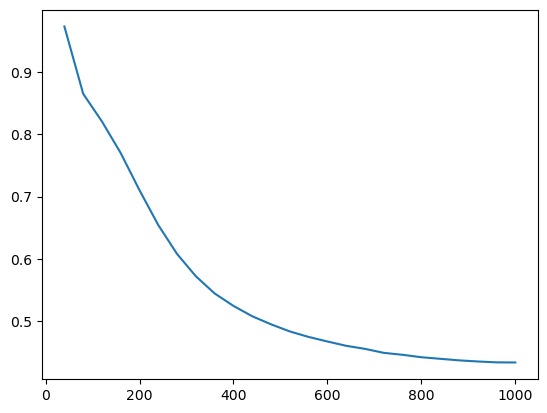

In [18]:
plt.plot(epochs, loss)

In [19]:
great.save("D:/Synthetic_Data_ESJ/Diab_syn_2024_prediab")

C:\Users\admin\anaconda3\envs\Paper1\lib\site-packages\be_great\great.py:430: UserWarning: Directory D:/Synthetic_Data_ESJ/Diab_syn_2024_prediab already exists and is overwritten now.
  warnings.warn(f"Directory {path} already exists and is overwritten now.")


#### Generate Samples

In [20]:
n_samples=1000

In [21]:
samples_custom = great.sample(n_samples, k=50, start_col="Outcome",start_col_dist={"2": 0.35, "1": 0.25, "0": 0.40})

1013it [00:45, 22.42it/s]                         


The run info:
- samples_custom = great.sample(n_samples, k=50, start_col="Outcome",start_col_dist={"2": 0.35, "1": 0.35, "0": 0.3})

In [22]:
samples_custom.shape

(1000, 15)

In [23]:
df_final_1 = samples_custom

In [24]:
df_final_1[df_final_1==np.inf]=np.nan
#df_final_2[df_final_2==np.inf]=np.nan

In [25]:
df_final_1 = df_final_1.dropna()
#df_final_2 = df_final_2.dropna()

In [26]:
df_final_1['Outcome'] = df_final_1['Outcome'].astype(int)
#df_final_2['Outcome'] = df_final_2['Outcome'].astype(int)

In [32]:
df_old['Outcome'].value_counts(normalize=True)

0    0.715385
1    0.153846
2    0.130769
Name: Outcome, dtype: float64

In [33]:
df_final_1['Outcome'].value_counts(normalize=True)

0    0.374
2    0.354
1    0.272
Name: Outcome, dtype: float64

In [36]:
df_final_1.to_csv("NIDDK-DF_SD-LLM_synbalanced.csv")

Citing

@article{borisov2022language,
  title={Language Models are Realistic Tabular Data Generators},
  author={Borisov, Vadim and Se{\ss}ler, Kathrin and Leemann, Tobias and Pawelczyk, Martin and Kasneci, Gjergji},
  journal={arXiv preprint arXiv:2210.06280},
  year={2022}
}